# Problem Description

Data preprocessing and applying a machine learning model for sentiment analysis on a dataset of reviews for various food from Amazon over more than 10 years; the goal is to classify these reviews into a positive and a negative category.

# Importing Required Packages

In [3]:
import os, sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
%pip install nltk
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import pickle

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Reading Dataset

In [4]:
df = pd.read_csv('Reviews.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


# Dropping Duplicates

In [6]:
df.drop_duplicates("Text", inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393579 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      393579 non-null  int64 
 1   ProductId               393579 non-null  object
 2   UserId                  393579 non-null  object
 3   ProfileName             393568 non-null  object
 4   HelpfulnessNumerator    393579 non-null  int64 
 5   HelpfulnessDenominator  393579 non-null  int64 
 6   Score                   393579 non-null  int64 
 7   Time                    393579 non-null  int64 
 8   Summary                 393576 non-null  object
 9   Text                    393579 non-null  object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


# Target Variable Pre-Processing

In [8]:
df['target']= ""
df.loc[df['Score'] <= 2, 'target'] = '0' 
df.loc[df['Score'] >= 3, 'target'] = '1' 
df['target'] = df['target'].astype(int)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


In [9]:
#Reducing dimensions for vectorizer and the model to work efficiently later on
df = df.iloc[0:250000]

# Plot Countplot for Target Data

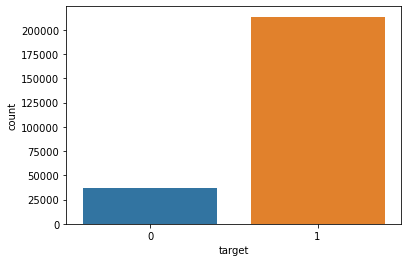

In [10]:
sns.countplot(x ='target', data = df)
plt.show()

# Balancing Target Data

In [11]:
NEG_N = df.target.value_counts()[0]
df_pos = df[df['target'] == 1].sample(NEG_N, replace=False)
df_balanced = pd.concat([df_pos, df[df.target == 0]])

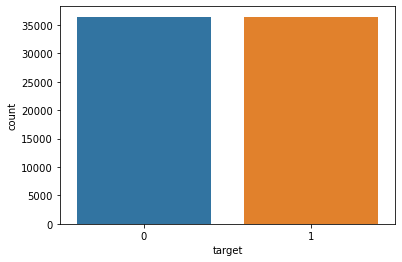

In [12]:
sns.countplot(x ='target', data = df_balanced)
plt.show()

# Text Pre-Processing

In [13]:
#stopwords
stop_words = set(stopwords.words('english'))
remove= ['not']
new_stop_words = stop_words.difference(remove)
#lemmatization
lemmatizer= WordNetLemmatizer()
#we used only limmatization not stemming as it's more convenient for the nature of our model and data

In [14]:
print(new_stop_words)

{'when', "isn't", 'you', 'off', 'itself', 'it', 'has', 'each', "mightn't", 'some', 'same', "you'd", 'm', 'with', 'of', 'to', 'very', 'how', 'up', 'other', 'do', "you're", 'doing', 'ain', 'hadn', 'which', 'we', 'yourselves', 'who', 'that', 'for', "should've", 'more', 'did', 'me', 'a', 't', 'themselves', 'what', "hasn't", 'so', 'am', "it's", 'been', 'further', "haven't", 'hers', 'being', 'had', "shouldn't", 'while', 'until', "don't", 'then', 'can', 'o', 'again', 'into', 'mightn', "needn't", 'they', 'be', "you've", 'whom', 'its', 'there', 'couldn', 'where', "mustn't", 'through', 'and', 'd', 'below', 'them', "shan't", 'hasn', 'nor', 'such', 'does', 'than', "you'll", 'don', 'was', 'own', 'having', 'are', "didn't", 's', 'about', 'down', 'on', 'll', 'will', 'those', 'doesn', "won't", 'should', 'yours', 'an', 'from', 'didn', 'no', 'herself', "aren't", 've', 'have', 'ourselves', 'theirs', 'our', 'but', 'against', 'my', 'why', "wouldn't", 'your', 'at', 'by', 'in', 'above', 'over', 'y', 'the', 'j

In [15]:
#tokenization
df_balanced['Text'] = df_balanced['Text'].astype(str)
df_balanced['Text'] = df_balanced['Text'].str.lower()
words= df_balanced['Text'].str.split() #tokenized text

In [16]:
def remove_stopwords(words):
    filter = [word for word in words if word not in new_stop_words]
    return filter

In [17]:
df_balanced['clean']= words.apply(lambda x: remove_stopwords(x))

In [18]:
#lemmatization
def lemmatization(clean):
    text = [lemmatizer.lemmatize(word) for word in clean]
    return text

In [19]:
df_balanced['limmatized']= df_balanced['clean'].apply(lambda x: lemmatization(x))

In [20]:
#use join to convert list to string for tf idf
df_balanced['limmatized'] = df_balanced['limmatized'].str.join(" ")

In [21]:
df_balanced.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target,clean,limmatized
129601,129602,B000VK4AZU,A2802H6A8LW6GY,D. Burke,0,0,4,1245974400,wonderful granola,"i have used galaxy ""not so sweet vanilla"" gran...",1,"[used, galaxy, ""not, sweet, vanilla"", granola,...","used galaxy ""not sweet vanilla"" granola year l..."
242555,242556,B002JIO0RU,A28ADA578VAX64,tommyt,1,1,4,1349308800,options,this adds so many options when you are trying ...,1,"[adds, many, options, trying, watch, carbs., n...","add many option trying watch carbs. no, not go..."
147290,147291,B000GZUBAS,AYPBBOCW24BIY,"J. C. Feldman ""Armchair Shopper""",2,3,4,1277424000,So delicious kids love them! But made in China,"such a good deal through amazon, and if you su...",1,"[good, deal, amazon,, subscribe,, even, better...","good deal amazon, subscribe, even better. howe..."
284147,284148,B0051COPH6,AOAOARIH72UWI,jt,0,0,4,1335398400,Good Stuff for Babies,babies love it and it is made with some good i...,1,"[babies, love, made, good, ingredients., conve...",baby love made good ingredients. convenient ta...
6549,6550,B003DKY5R8,AYJ7DFWD5XO1A,BryanK,0,0,5,1347062400,Arrived quickly,i ordeed this product because this tea is real...,1,"[ordeed, product, tea, really, good., shipment...",ordeed product tea really good. shipment came ...


# Split Test & Training Data

In [22]:
X=df_balanced.limmatized
y=df_balanced.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Text Embedding

In [23]:
vectorizer = TfidfVectorizer(max_features=10000)
vectorizer_tfidf = vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [24]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((51058, 10000), (21882, 10000))

# Modelling

In [25]:
clf = RandomForestClassifier(max_depth=4)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 77.26%


In [26]:
confusion_matrix(y_test, preds)

array([[8175, 2720],
       [2255, 8732]], dtype=int64)

# Raw Instance Prediction

In [27]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c = review
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [28]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst ever tasted"

In [29]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [30]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

# Saving Models for Deployment

In [33]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)

pickle.dump(clf, open(model_name, 'wb'))
pickle.dump(vectorizer, open(vectorizer_name, 'wb'))

# Loading Models Again and Testing them

In [34]:
loaded_model = pickle.load(open(model_name, 'rb'))
loaded_vect = pickle.load(open(vectorizer_name, 'rb'))

In [35]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [36]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'